In [1]:
import sys
sys.path.append('../')

In [2]:
import pennylane as qml 
from pennylane import numpy as np 
import matplotlib.pyplot as plt 
from main import VarFourier
from main import RY_ansatz, Rot_ansatz#, ZGR_ansatz, symmetric_ansatz#, interpolation
from main import QFT

In [3]:
class interpolation():
    def __init__(self, base_ansatz, extra_qubits) -> None:
        self.base_ansatz = base_ansatz
        self.extra_qubits = extra_qubits
        self.num_qubits_tot = self.base_ansatz.num_qubits + self.extra_qubits
        self.num_params = self.base_ansatz.num_params

    
    def construct_circuit(self, params):
        
        # Make previous circuit
        self.base_ansatz.construct_circuit(params)
        
        qml.Barrier()

        # now we transform to momentum space
        QFT( self.base_ansatz.num_qubits , n_init=self.extra_qubits )
        #qml.QFT(range(self.base_ansatz.num_qubits))
        qml.Barrier()
        # we entangle everything
        last_qubit_prev = self.base_ansatz.num_qubits - 1
        
        for wire in range(0,self.extra_qubits):
            qml.CNOT([self.extra_qubits, wire])
        
        # and finnaly we undo the QFT
        
        qml.Barrier()
        QFT(self.num_qubits_tot, inverse = True, n_init=0)
        #qml.adjoint( qml.QFT( range(self.num_qubits_tot) ) )


def QFT(n_wires, semi_classical=False, inverse=False, n_init=0):
    if semi_classical:
        mid_measures = []
        for n in range( n_init, n_wires ):
            qml.Hadamard( wires=n )
            if n < n_wires-1:
                mid_measure = qml.measure( wires=n ) 
                mid_measures.append( mid_measure )
                for m in range(1,n_wires-n):
                    qml.cond( mid_measure, 
                                qml.PhaseShift )( np.pi/2**m, 
                                            wires=n+m ) 
    else:
        '''
        for n in range( n_wires ):
            qml.Hadamard(wires=num_qubits-n-1)
            for m in range(1,n_wires-n):
                qml.ControlledPhaseShift( np.pi/2**m, wires=[num_qubits-n-1-m,num_qubits-n-1]  )
        '''
        if inverse:
            for n in reversed(range( n_init , n_wires )):
                qml.Hadamard(wires=n)
                for m in reversed(range(1,n_wires-n)):
                    qml.ControlledPhaseShift( -np.pi/2**m, 
                                                wires=[n,n+m]  )
        else:
            for n in range( n_init , n_wires ):
                qml.Hadamard(wires=n)
                for m in range(1,n_wires-n):
                    qml.ControlledPhaseShift( np.pi/2**m, 
                                                wires=[n,n+m]  )

In [41]:
class ZGR_ansatz():
    """ Class to construct the ZGR variational circuit."""

    def __init__(self, num_qubits, layers=1, bond_dim = np.inf, n_initial = 0):
        """Constructor.
        
        Args:
            num_qubits (int): number of qubits of the circuit.
        """
        super().__init__()
        self.num_qubits = num_qubits
        self.layers = layers
        self.bond_dim = bond_dim
        self.N_init = n_initial
        self.num_cx = self.num_entangling_gates()
        self.num_params = self.num_cx + self.layers
        

    def num_entangling_gates(self):
        """
        Obtain the number of entangling gates.
        """
        num_cx = 0
        for _ in range(self.layers):
            for target in range(self.N_init,self.num_qubits):
                last = 2**target - 1
                max_l = 2 ** min(target, (self.bond_dim-1))
                for l in range(max_l):
                    min_control = max(0, target + 1 - self.bond_dim)
                    for control in range(min_control, target):
                        if (last ^ l) & (1 << (target-control-1)):
                            num_cx += 1
                            break
                    last = l
                    
        return self.layers * num_cx

    def construct_circuit(self, parameters ):
        """
        Construct the variational form, given its parameters.

        Returns:
            QuantumCircuit: a quantum circuit with given 'parameters'.

        """
        wires = list(range(self.N_init,self.num_qubits))[::-1]
        param_idx = 0
        for _ in range(self.layers):
            for target in range(self.N_init,self.num_qubits):
                last = 2**target - 1
                max_l = 2 ** min(target, (self.bond_dim-1))
                for l in range(max_l):
                    min_control = max(0, target + 1 - self.bond_dim)
                    for control in range(min_control, target):
                        if (last ^ l) & (1 << (target-control-1)):
                            print(f'First parameter = {self.num_qubits-1-control}')
                            print(f'Second parameter = {self.num_qubits-1-target}')

                            qml.CNOT(wires=[wires[self.num_qubits-1-control], wires[self.num_qubits-1-target]])
                            break
                    last = l
                    qml.RY(parameters[param_idx], wires=wires[self.num_qubits-1-target])
                    param_idx += 1
                    
    def extend_params(self, old_ansatz : 'ZGR_ansatz', old_params):

        old_bond_dim = old_ansatz.bond_dim
        err_msg = "Both circuits must have the same number of qubits"
        assert old_ansatz.num_qubits == self.num_qubits, err_msg

        err_msg = "Can not extend the parameters from a circuit with a larger bond dimension"
        assert self.bond_dim >= old_ansatz.bond_dim, err_msg


        new_params = np.zeros(self.num_params)
        new_params_idx = 0
        old_params_idx = 0
        
        for _ in range(self.layers):
            for target in range(self.N_init,self.num_qubits):
                last = 2**target - 1
                max_l = 2 ** min(target, (self.bond_dim-1))
                for l in range(max_l):
                    min_control = max(0, target + 1 - self.bond_dim)
                    for control in range(min_control, target):
                        if (last ^ l) & (1 << (target-control-1)):
                            #qml.CNOT(wires=[wires[self.num_qubits-1-control], wires[self.num_qubits-1-target]])
                            break
                    last = l
                    # Is l considered in the smaller circuit?
                    if l > max_l - 2**(old_bond_dim-1) - 1:
                        new_params[new_params_idx] = old_params[old_params_idx]
                        old_params_idx += 1
                        new_params_idx += 1
                        #qml.RY(parameters[param_idx], wires=wires[self.num_qubits-1-target])
                    else:
                        new_params_idx += 1
        return new_params

In [27]:
num_qubits = 3

In [28]:
def init_state():
    #qml.AmplitudeEmbedding(features=vecs[:,0], wires=range(num_qubits))
    pass 

In [29]:
num_layers = 1
var_state_class = ZGR_ansatz(num_qubits, num_layers, n_initial=0)
#var_state_class = symmetric_ansatz(var_state_class)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_class.construct_circuit
num_params = var_state_class.num_params


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

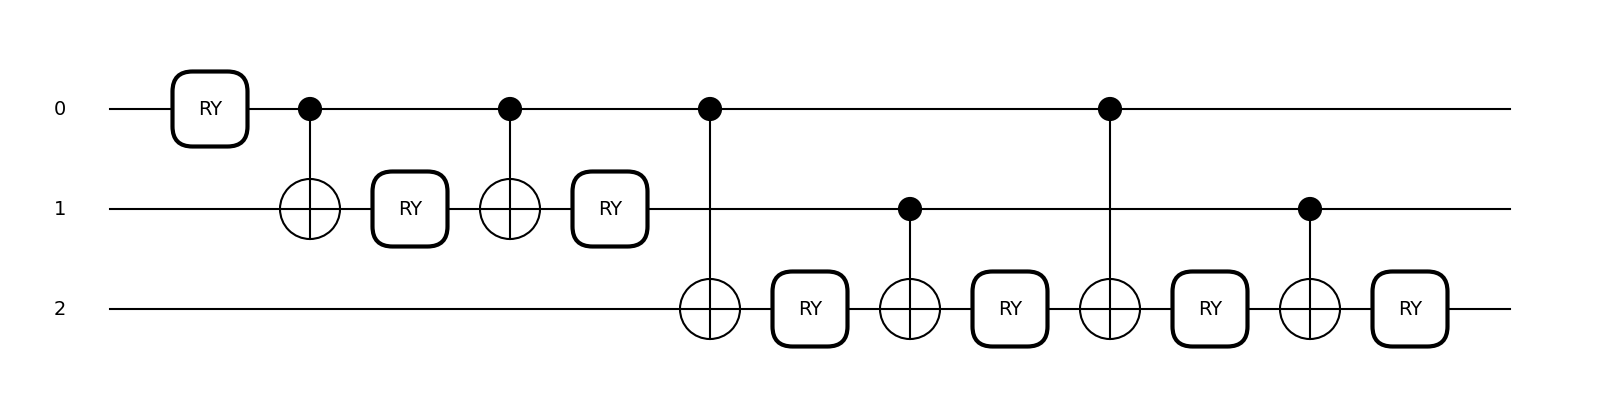

In [30]:
qml.draw_mpl( var_state )( num_params*[0] )

In [14]:
device = qml.device( "lightning.qubit", 
                    wires=num_qubits)

varqft = VarFourier( num_qubits,
                    lambda x : -0.5/(0.0+np.abs(x)),
                    lambda p : 0.5*p**2,
                    device,
                    xmin=-10,
                    xmax=10,
                    var_state  = var_state,
                    init_state = init_state,
                    semi_classical=False
                    )

In [15]:
vals, vecs = varqft.energy_eigens()
val = vals[0]
vec = vecs[:,0]
val2 = vals[1]
vec2 = vecs[:,1] 
val3 = vals[2]
vec3 = vecs[:,2] 
val4 = vals[3]
vec4 = vecs[:,3] 
val5 = vals[4]
vec5 = vecs[:,4] 
vals

array([-0.29447935, -0.13488428, -0.05024293,  0.00694895,  0.04197499,
        0.18295047,  0.24502973,  0.49178057])

In [16]:
beta = np.exp(-0.5*np.sqrt(np.abs(val)))/(2*np.sqrt(np.abs(val)))

In [17]:
beta

0.7024340622313099

In [18]:
1/16

0.0625

In [19]:
vals[3]/vals[0]

-0.023597399438534738

In [20]:
params_init = np.random.randn( num_params )*0.001
#params_pre = params_ground[-1]
#params_ground, energies_ground = varqft.run( np.concatenate((params_pre,np.random.randn(num_qubits)*1e-3)), max_iterations=500, learning_rate=0.5, conv_tol=1e-6 )
params_ground, energies_ground = varqft.run( params_init , max_iterations=300, learning_rate=0.2, conv_tol=1e-6 )

In [21]:
#params_init

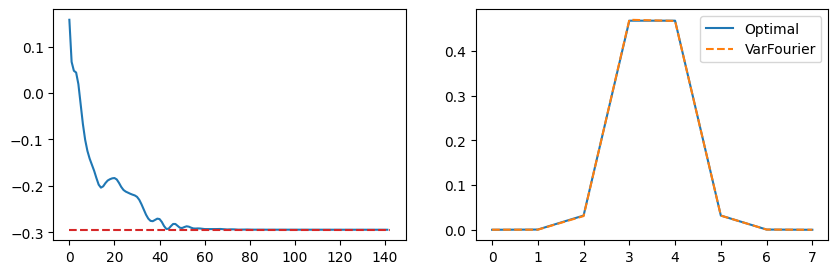

In [22]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( energies_ground )
ax[0].hlines( val, 0, len(energies_ground), colors='tab:red', linestyles='--' ) 

ground_state = varqft.state( params_ground[-1] )

ax[1].plot( np.abs(vecs[:,0])**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier']) 

In [23]:
abs(np.vdot( ground_state, vec ))**2

0.999838068675178

In [42]:
num_layers = 1
extra = 2
var_state_class = ZGR_ansatz(num_qubits, num_layers, n_initial=extra)

var_state_interpol = interpolation(var_state_class, extra_qubits=extra)

#var_state_class = Rot_ansatz(num_qubits,num_layers)
#var_state_class = RY_ansatz(num_qubits,num_layers)
var_state = var_state_interpol.construct_circuit
#num_params = var_state_class.num_params


In [43]:
fig, ax = qml.draw_mpl( var_state , style='pennylane' )( params_ground[-1] )
fig.show()

First parameter = 2
Second parameter = 0


IndexError: list index out of range

In [158]:
device2 = qml.device( "lightning.qubit", 
                    wires=num_qubits + extra)

varqft2 = VarFourier( num_qubits+extra,
                    lambda x : -0.5/(0.0+np.abs(x)),
                    lambda p : 0.5*p**2,
                    device2,
                    xmin=-10,
                    xmax=10,
                    var_state  = var_state,
                    init_state = init_state,
                    semi_classical=False
                    )

In [159]:
vals2, vecs2 = varqft2.energy_eigens()
val2 = vals2[0]
vec2 = vecs2[:,0]

In [160]:
ground_state = varqft2.state( params_ground[-1] )


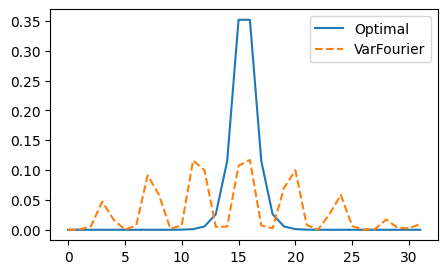

In [161]:
fig, ax = plt.subplots( 1, 1, figsize=(5,3) ) 

ground_state2 = varqft2.state( params_ground[-1] )

ax.plot( np.abs(vecs2[:,0])**2) 
ax.plot( np.abs(ground_state2)**2, '--' ) 
ax.legend(['Optimal','VarFourier']) 